# Kickstarter Projects
This is a Notebook to work the kickstarter_projects kaggle dataset. We're about to see how bla bla...

database link: https://www.kaggle.com/datasets/kemical/kickstarter-projects

atributs inicials : ID, name, category, main_category, currency, deadline, goal, launched, pledged, state, backers, country, usd pledged

In [2]:
# Imports
import numpy as np
import pandas as pd
import datetime as dt
import time
import seaborn as sns

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import *
from sklearn import svm,datasets,tree,neighbors,metrics

import category_encoders as ce
import matplotlib.pyplot as plt

Usaremos el segundo dataset puesto que ambos tienen algunos atributos diferentes, ambos tienen instancias en común costosas de filtrar, ambos tienen más de 300000 instancias (información más que suficiente) y el segundo tiene los atributos monetarios ya convertidos a USD

In [6]:
#Load datasets
df1 = pd.read_csv('../data/ks-projects-201612.csv', encoding = 'utf-8', encoding_errors = 'replace')
df2 = pd.read_csv('../data/ks-projects-201801.csv', encoding = 'cp1252', encoding_errors = 'replace')

df = pd.read_csv('../data/ks-projects-201801.csv', encoding = 'cp1252', encoding_errors = 'replace')
df2

C:\Users\javie\AppData\Local\Temp\ipykernel_2640\3043271149.py:2: DtypeWarning: Columns (13,14,15) have mixed types. Specify dtype option on import or set low_memory=False.
  df1 = pd.read_csv('../data/ks-projects-201612.csv', encoding = 'utf-8', encoding_errors = 'replace')


,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd pledged,usd_pledged_real,usd_goal_real
0,1000002330,The Songs of Adelaide & Abullah,Poetry,Publishing,GBP,2015-10-09,1000.0,2015-08-11 12:12:28,0.0,failed,0,GB,0.0,0.0,1533.95
1,1000003930,Greeting From Earth: ZGAC Arts Capsule For ET,Narrative Film,Film & Video,USD,2017-11-01,30000.0,2017-09-02 04:43:57,2421.0,failed,15,US,100.0,2421.0,30000.00
2,1000004038,Where is Hank?,Narrative Film,Film & Video,USD,2013-02-26,45000.0,2013-01-12 00:20:50,220.0,failed,3,US,220.0,220.0,45000.00
3,1000007540,ToshiCapital Rekordz Needs Help to Complete Album,Music,Music,USD,2012-04-16,5000.0,2012-03-17 03:24:11,1.0,failed,1,US,1.0,1.0,5000.00
4,1000011046,Community Film Project: The Art of Neighborhoo...,Film & Video,Film & Video,USD,2015-08-29,19500.0,2015-07-04 08:35:03,1283.0,canceled,14,US,1283.0,1283.0,19500.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
378656,999976400,ChknTruk Nationwide Charity Drive 2014 (Canceled),Documentary,Film & Video,USD,2014-10-17,50000.0,2014-09-17 02:35:30,25.0,canceled,1,US,25.0,25.0,50000.00
378657,999977640,The Tribe,Narrative Film,Film & Video,USD,2011-07-19,1500.0,2011-06-22 03:35:14,155.0,failed,5,US,155.0,155.0,1500.00
378658,999986353,Walls of Remedy- New lesbian Romantic Comedy f...,Narrative Film,Film & Video,USD,2010-08-16,15000.0,2010-07-01 19:40:30,20.0,failed,1,US,20.0,20.0,15000.00
378659,999987933,BioDefense Education Kit,Technology,Technology,USD,2016-02-13,15000.0,2016-01-13 18:13:53,200.0,failed,6,US,200.0,200.0,15000.00


In [3]:
# Podemos ver atributos que no nos dicen nada como ID, name, usd_pledged (usd_pledged_real millor)
df.head()

,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd pledged,usd_pledged_real,usd_goal_real
0,1000002330,The Songs of Adelaide & Abullah,Poetry,Publishing,GBP,2015-10-09,1000.0,2015-08-11 12:12:28,0.0,failed,0,GB,0.0,0.0,1533.95
1,1000003930,Greeting From Earth: ZGAC Arts Capsule For ET,Narrative Film,Film & Video,USD,2017-11-01,30000.0,2017-09-02 04:43:57,2421.0,failed,15,US,100.0,2421.0,30000.00
2,1000004038,Where is Hank?,Narrative Film,Film & Video,USD,2013-02-26,45000.0,2013-01-12 00:20:50,220.0,failed,3,US,220.0,220.0,45000.00
3,1000007540,ToshiCapital Rekordz Needs Help to Complete Album,Music,Music,USD,2012-04-16,5000.0,2012-03-17 03:24:11,1.0,failed,1,US,1.0,1.0,5000.00
4,1000011046,Community Film Project: The Art of Neighborhoo...,Film & Video,Film & Video,USD,2015-08-29,19500.0,2015-07-04 08:35:03,1283.0,canceled,14,US,1283.0,1283.0,19500.00


In [4]:
df = df.drop(columns=['ID', 'name', 'usd pledged', 'pledged', 'goal'])
print(df.isnull().sum(axis = 0))
print((df == '?').sum(axis=0))

category            0
main_category       0
currency            0
deadline            0
launched            0
state               0
backers             0
country             0
usd_pledged_real    0
usd_goal_real       0
dtype: int64
category            0
main_category       0
currency            0
deadline            0
launched            0
state               0
backers             0
country             0
usd_pledged_real    0
usd_goal_real       0
dtype: int64


Hemos tenido mucha suerte al no tener NaNs

In [5]:
# definimos nuevos atributos
df['elapsed_days'] = (pd.to_datetime(df['deadline'])-pd.to_datetime(df['launched'])).dt.total_seconds()/(3600*24)
#df['deadline'] = (pd.to_datetime(df['deadline']) - dt.datetime(2009,1,1)).dt.total_seconds()
#df['launched'] = (pd.to_datetime(df['launched']) - dt.datetime(2009,1,1)).dt.total_seconds()
df = df.drop(columns=['launched', 'deadline'])

df['pledged/backer'] = df['usd_pledged_real']/df['backers']
df['pledged/backer'].fillna(value = 0, inplace=True)
a = np.max(df['pledged/backer'])
df.loc[df["pledged/backer"] == a, "pledged/backer"] = 0

col_list = list(df.columns)
x, y = col_list.index(df.columns[-1]), col_list.index('state')
col_list[y], col_list[x] = col_list[x], col_list[y]
df = df[col_list]

col_list = list(df.columns)
x, y = col_list.index('pledged/backer'), col_list.index('country')
col_list[y], col_list[x] = col_list[x], col_list[y]
df = df[col_list]

In [6]:
aux = df['state'].to_numpy()
aux, auxn = np.unique(aux, return_counts = True)
print(aux)
print(auxn)
#should we drop live all except failed and successful?
print((auxn[1] + auxn[3])/auxn.sum())

['canceled' 'failed' 'live' 'successful' 'suspended' 'undefined']
[ 38779 197719   2799 133956   1846   3562]
0.8759153966212523


In [7]:
# nos quedamos solo con los registros fallidos o logrados (~88%)
df = df[np.logical_or(df['state'] == 'failed',df['state'] == 'successful')]
df.loc[df["state"] == "failed", "state"] = 0
df.loc[df["state"] == "successful", "state"] = 1

Veamos cómo son nuestros atributos categóricos

In [8]:
#23 paises distintos
aux = df['country'].to_numpy()
aux, auxn = np.unique(aux, return_counts = True)
print(aux)
print(auxn)
print(aux.shape)

['AT' 'AU' 'BE' 'CA' 'CH' 'DE' 'DK' 'ES' 'FR' 'GB' 'HK' 'IE' 'IT' 'JP'
 'LU' 'MX' 'N,0"' 'NL' 'NO' 'NZ' 'SE' 'SG' 'US']
[   485   6616    523  12370    652   3436    926   1873   2520  29454
    477    683   2369     23     57   1411    210   2411    582   1274
   1509    454 261360]
(23,)


In [9]:
#15 categorias principales
aux = df['main_category'].to_numpy()
aux, auxn = np.unique(aux, return_counts = True)
print(aux)
print(auxn)
print(aux.shape)

['Art' 'Comics' 'Crafts' 'Dance' 'Design' 'Fashion' 'Film & Video' 'Food'
 'Games' 'Journalism' 'Music' 'Photography' 'Publishing' 'Technology'
 'Theater']
[25641  9878  7818  3573 25364 19775 56527 22054 28521  4149 45949  9689
 35445 27050 10242]
(15,)


In [10]:
#159 categorias
aux = df['category'].to_numpy()
aux, auxn = np.unique(aux, return_counts = True)
print(aux)
print(auxn)
print(aux.shape)

['3D Printing' 'Academic' 'Accessories' 'Action' 'Animals' 'Animation'
 'Anthologies' 'Apparel' 'Apps' 'Architecture' 'Art' 'Art Books' 'Audio'
 'Bacon' 'Blues' 'Calendars' 'Camera Equipment' 'Candles' 'Ceramics'
 "Children's Books" 'Childrenswear' 'Chiptune' 'Civic Design'
 'Classical Music' 'Comedy' 'Comic Books' 'Comics' 'Community Gardens'
 'Conceptual Art' 'Cookbooks' 'Country & Folk' 'Couture' 'Crafts'
 'Crochet' 'DIY' 'DIY Electronics' 'Dance' 'Design' 'Digital Art'
 'Documentary' 'Drama' 'Drinks' 'Electronic Music' 'Embroidery' 'Events'
 'Experimental' 'Fabrication Tools' 'Faith' 'Family' 'Fantasy'
 "Farmer's Markets" 'Farms' 'Fashion' 'Festivals' 'Fiction' 'Film & Video'
 'Fine Art' 'Flight' 'Food' 'Food Trucks' 'Footwear' 'Gadgets' 'Games'
 'Gaming Hardware' 'Glass' 'Graphic Design' 'Graphic Novels' 'Hardware'
 'Hip-Hop' 'Horror' 'Illustration' 'Immersive' 'Indie Rock'
 'Installations' 'Interactive Design' 'Jazz' 'Jewelry' 'Journalism' 'Kids'
 'Knitting' 'Latin' 'Letterpress'

In [11]:
attributes = df.columns
for i in range(len(attributes)):
    print(i, attributes[i])

0 category
1 main_category
2 currency
3 country
4 backers
5 pledged/backer
6 usd_pledged_real
7 usd_goal_real
8 elapsed_days
9 state


In [12]:
df.describe()

,backers,pledged/backer,usd_pledged_real,usd_goal_real,elapsed_days
count,331675.000000,331675.000000,3.316750e+05,3.316750e+05,331675.000000
mean,116.381581,66.087346,9.943461e+03,4.151000e+04,33.389378
std,965.427268,131.610145,9.673293e+04,1.108930e+06,12.723385
min,0.000000,0.000000,0.000000e+00,1.000000e-02,0.005058
25%,2.000000,16.673375,5.000000e+01,2.000000e+03,29.088929
50%,15.000000,42.304593,7.880000e+02,5.000000e+03,29.656759
75%,63.000000,77.533542,4.608000e+03,1.500000e+04,35.705966
max,219382.000000,10000.000000,2.033899e+07,1.663614e+08,91.962650


In [13]:
# outliers
df1 = df[df['backers'] <= 200]
df1 = df1[df1['usd_goal_real'] <= 10000]
df1 = df1[df1['usd_goal_real'] >= 10]
#df1 = df1[df1['usd_pledged_real'] <= 100000]
df1 = df1[df1['pledged/backer'] <= 300]
#df1 = df1[df1['pledged/backer'] > 0] #uncomment to see gamma distribution
df = df1

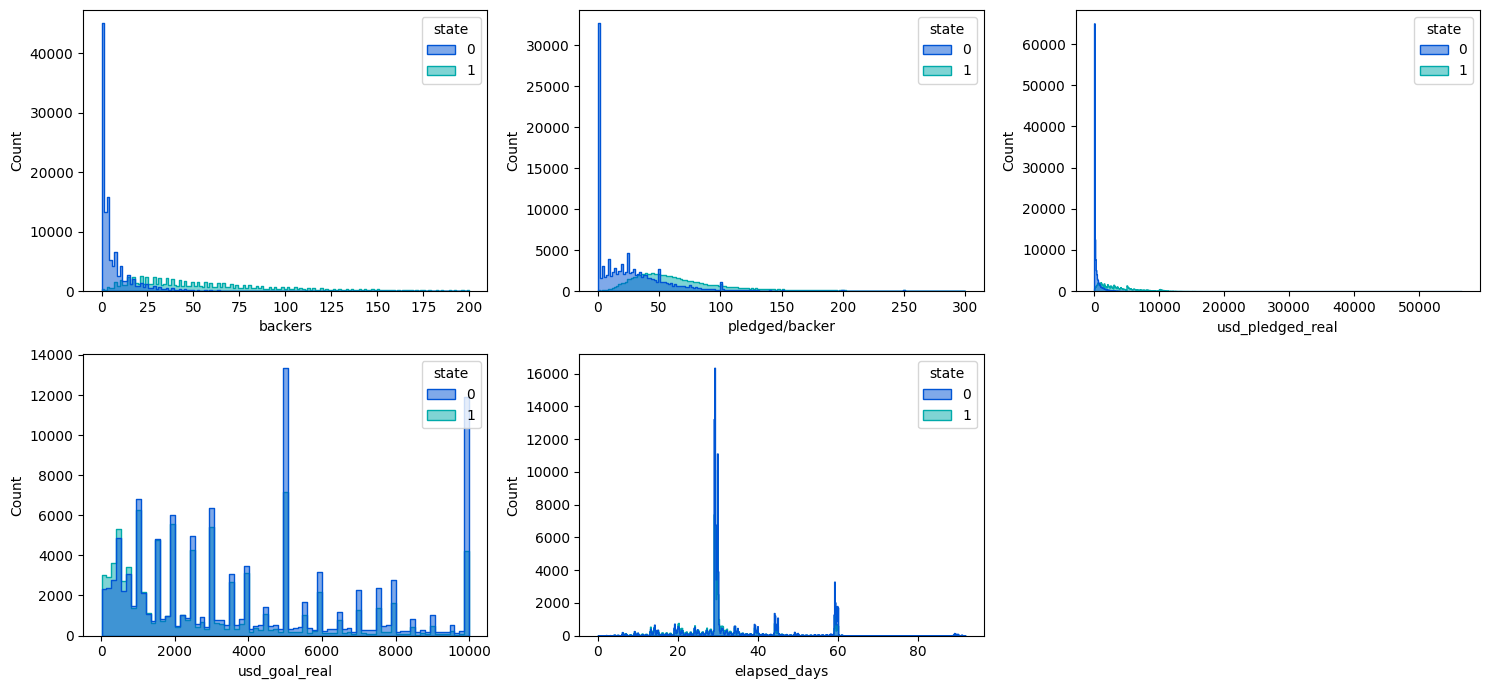

In [14]:
# distribució dels atributs segons els dos valors de l'state
plt.figure(figsize = (15,10), tight_layout = True)

for i, feature in enumerate(df.columns[4:9]):
    plt.subplot(3,3,i+1)
    sns.histplot(data = df1, x =feature, palette='winter', hue = 'state',alpha = 0.5, element="step" )

In [15]:
df.dtypes

category             object
main_category        object
currency             object
country              object
backers               int64
pledged/backer      float64
usd_pledged_real    float64
usd_goal_real       float64
elapsed_days        float64
state                object
dtype: object

C:\Users\javie\AppData\Local\Temp\ipykernel_34592\3108248877.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(df.corr(), ax = ax, annot = True)


<AxesSubplot: >

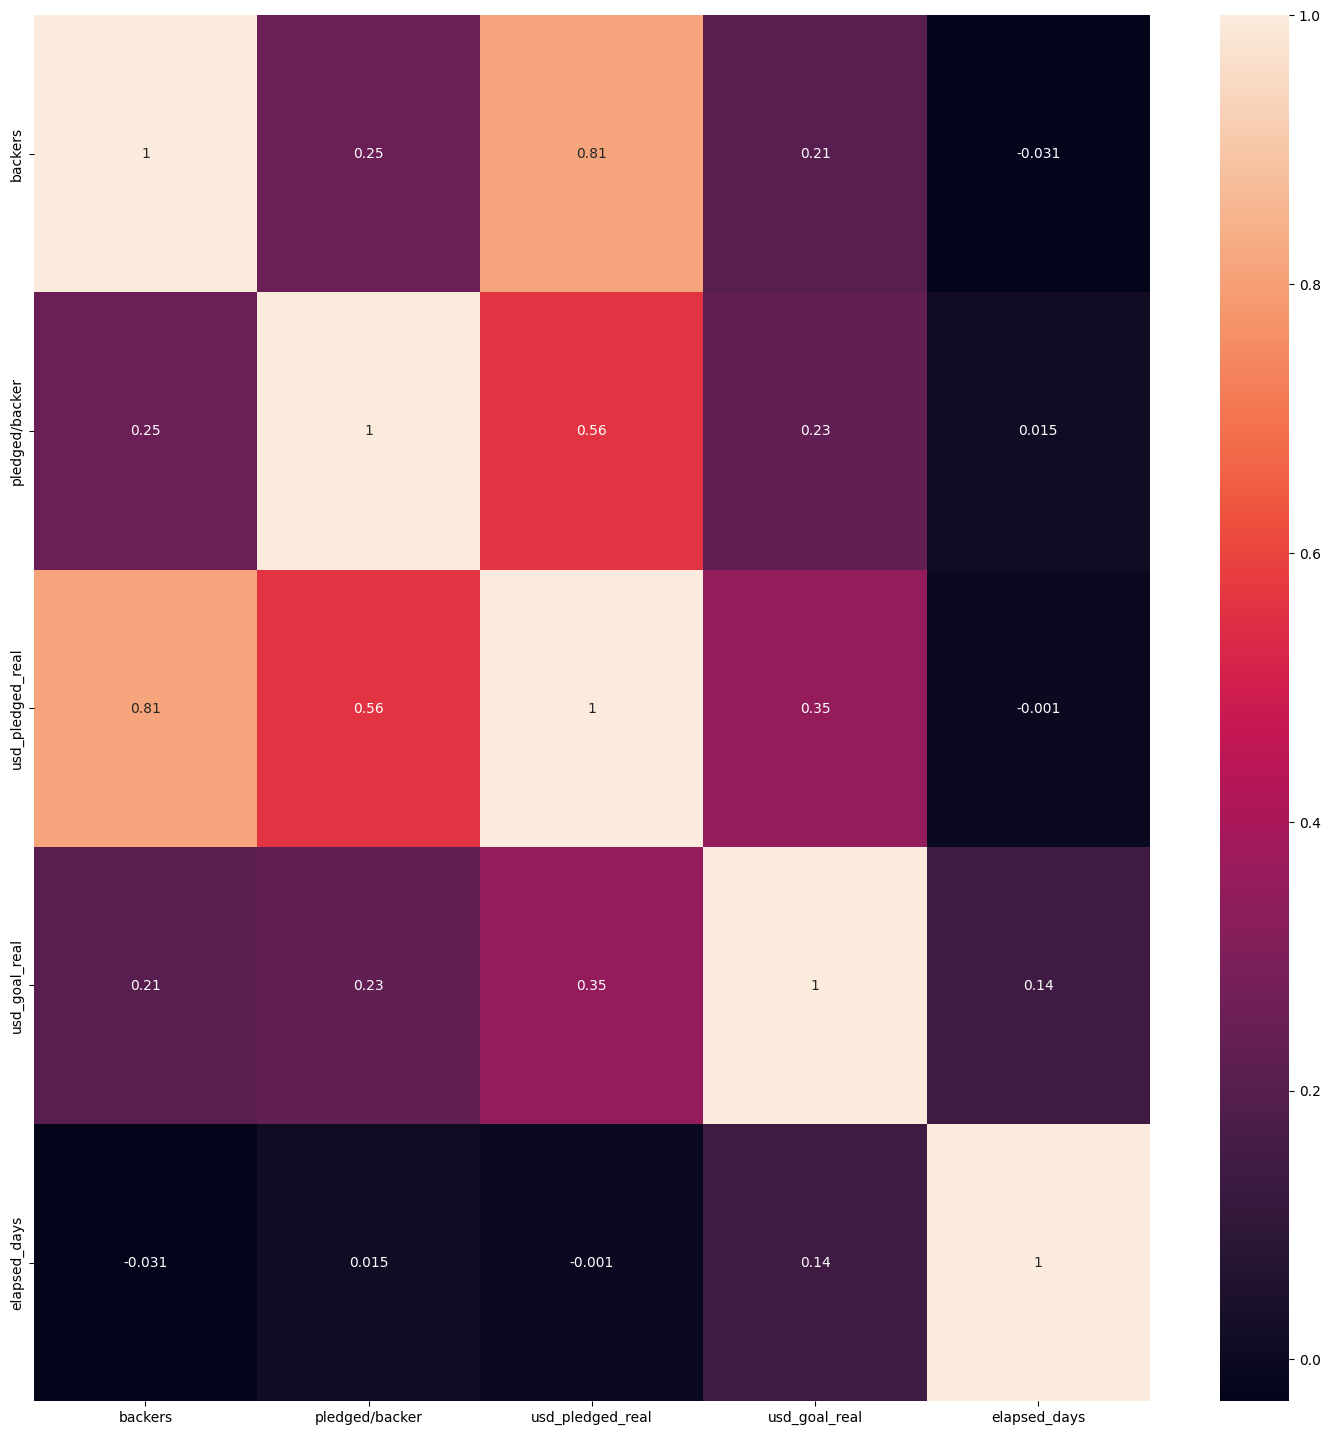

In [16]:
fig, ax = plt.subplots(figsize = (18,18))
sns.heatmap(df.corr(), ax = ax, annot = True)

In [17]:
df = df.drop(columns=['backers', 'pledged/backer', 'usd_pledged_real', 'elapsed_days'])

In [18]:
ce_OHE = ce.OneHotEncoder(cols=df.columns[0:4])

dff = ce_OHE.fit_transform(df)
dff

C:\Users\javie\environments\data_science\lib\site-packages\category_encoders\one_hot.py:145: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for cat_name, class_ in values.iteritems():
C:\Users\javie\environments\data_science\lib\site-packages\category_encoders\one_hot.py:145: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for cat_name, class_ in values.iteritems():
C:\Users\javie\environments\data_science\lib\site-packages\category_encoders\one_hot.py:145: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for cat_name, class_ in values.iteritems():
C:\Users\javie\environments\data_science\lib\site-packages\category_encoders\one_hot.py:145: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for cat_name, class_ in values.iteritems():


,category_1,category_2,category_3,category_4,category_5,category_6,category_7,category_8,category_9,category_10,...,country_16,country_17,country_18,country_19,country_20,country_21,country_22,country_23,usd_goal_real,state
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1533.95,0
3,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,5000.00,0
6,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1000.00,1
10,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,2406.39,0
12,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,5000.00,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
378652,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,2675.19,1
378653,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1700.00,0
378654,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,6500.00,0
378657,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1500.00,0


In [19]:
ce_be = ce.BinaryEncoder(cols=df.columns[0:4]);

# transform the data
data_binary = ce_be.fit_transform(df);
dff = data_binary
dff

,category_0,category_1,category_2,category_3,category_4,category_5,category_6,category_7,main_category_0,main_category_1,...,currency_1,currency_2,currency_3,country_0,country_1,country_2,country_3,country_4,usd_goal_real,state
0,0,0,0,0,0,0,0,1,0,0,...,0,0,1,0,0,0,0,1,1533.95,0
3,0,0,0,0,0,0,1,0,0,0,...,0,1,0,0,0,0,1,0,5000.00,0
6,0,0,0,0,0,0,1,1,0,0,...,0,1,0,0,0,0,1,0,1000.00,1
10,0,0,0,0,0,1,0,0,0,0,...,0,1,1,0,0,0,1,1,2406.39,0
12,0,0,0,0,0,1,0,1,0,1,...,0,1,0,0,0,0,1,0,5000.00,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
378652,0,0,0,1,0,1,0,0,1,0,...,1,0,1,0,0,1,0,1,2675.19,1
378653,0,0,0,1,0,1,0,0,1,0,...,0,1,0,0,0,0,1,0,1700.00,0
378654,0,1,1,0,1,1,0,0,0,0,...,0,1,0,0,0,0,1,0,6500.00,0
378657,0,0,0,1,0,1,0,1,1,0,...,0,1,0,0,0,0,1,0,1500.00,0


In [20]:
mm = MinMaxScaler()
mm_data = mm.fit_transform(dff)
mm_data

array([[0.        , 0.        , 0.        , ..., 1.        , 0.15254755,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.4994995 ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.0990991 ,
        1.        ],
       ...,
       [0.        , 1.        , 1.        , ..., 0.        , 0.64964965,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.14914915,
        0.        ],
       [0.        , 0.        , 1.        , ..., 0.        , 0.1991992 ,
        0.        ]])

# Train/Test

In [21]:
X = mm_data[:, :-1]
y = mm_data[:,-1].astype(int)
x_t, x_v, y_t, y_v = train_test_split(X, y, test_size = 0.3, random_state = 42)
resultados = {}

KNN amb k 50
f1 score: 0.5660986616868969
accuracy: 0.6523920835281284
recall: 0.5215225260743342
precision: 0.6190071042668142
aug roc:  0.6372949419365026


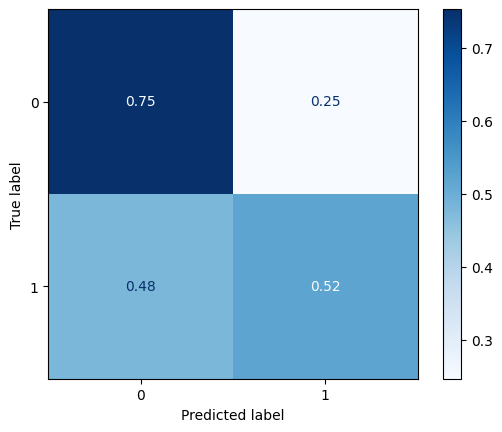

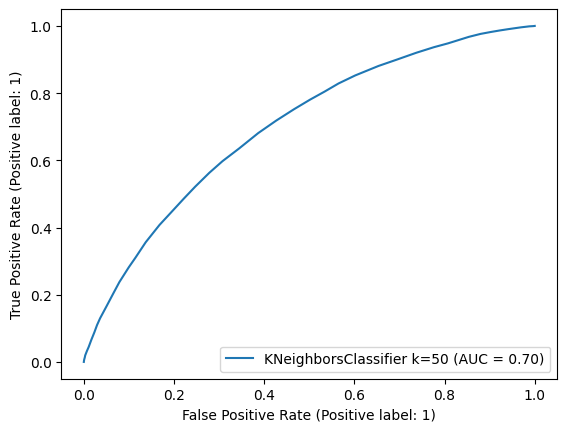

In [33]:
from sklearn.neighbors import KNeighborsClassifier
for i in range(50,61,80):
    knn = KNeighborsClassifier(n_neighbors=i, weights = 'uniform')
    knn.fit(x_t, y_t)
    preds = knn.predict(x_v)
    print('KNN amb k ' + str(i))
    d = {}
    # metricas
    #d['model'] = 'knn k=' + str(i)
    d['f1 score'] = f1_score(y_v, preds)
    print('f1 score: ' + str(d['f1 score']))
    d['accuracy'] = accuracy_score(y_v, preds)
    print('accuracy: ' + str(d['accuracy']))
    d['recall'] = recall_score(y_v, preds)
    print('recall: ' + str(d['recall']))
    d['precision'] = precision_score(y_v, preds)
    print('precision: ' + str(d['precision']))
    d['aug roc'] = sklearn.metrics.roc_auc_score(y_v,  preds)
    print('aug roc: ', d['aug roc'])
    #confusion matrix
    cm = metrics.confusion_matrix(y_v, preds, normalize = 'true')
    d['confusion matrix'] = cm
    resultados['knn k=' + str(i)] = d
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp = disp.plot(cmap=plt.cm.Blues)
    plt.show()
    RocCurveDisplay.from_estimator(knn, x_v, y_v, name = 'KNeighborsClassifier k=' + str(i))
    


In [23]:
print(np.unique(y_v, return_counts = True))
print(np.unique(y_t, return_counts = True))

(array([0, 1]), array([36269, 27901], dtype=int64))
(array([0, 1]), array([84555, 65173], dtype=int64))


In [24]:
from sklearn.model_selection import cross_validate
def cross_validation(model, _X, _y, _cv=5):
      '''Function to perform 5 Folds Cross-Validation
       Parameters
       ----------
      model: Python Class, default=None
              This is the machine learning algorithm to be used for training.
      _X: array
           This is the matrix of features.
      _y: array
           This is the target variable.
      _cv: int, default=5
          Determines the number of folds for cross-validation.
       Returns
       -------
       The function returns a dictionary containing the metrics 'accuracy', 'precision',
       'recall', 'f1' for both training set and validation set.
      '''
      _scoring = ['accuracy', 'precision', 'recall', 'f1']
      results = cross_validate(estimator=model,
                               X=_X,
                               y=_y,
                               cv=_cv,
                               scoring=_scoring,
                               return_train_score=True)
      
      return {"Training Accuracy scores": results['train_accuracy'],
              "Mean Training Accuracy": results['train_accuracy'].mean()*100,
              "Training Precision scores": results['train_precision'],
              "Mean Training Precision": results['train_precision'].mean(),
              "Training Recall scores": results['train_recall'],
              "Mean Training Recall": results['train_recall'].mean(),
              "Training F1 scores": results['train_f1'],
              "Mean Training F1 Score": results['train_f1'].mean(),
              "Validation Accuracy scores": results['test_accuracy'],
              "Mean Validation Accuracy": results['test_accuracy'].mean()*100,
              "Validation Precision scores": results['test_precision'],
              "Mean Validation Precision": results['test_precision'].mean(),
              "Validation Recall scores": results['test_recall'],
              "Mean Validation Recall": results['test_recall'].mean(),
              "Validation F1 scores": results['test_f1'],
              "Mean Validation F1 Score": results['test_f1'].mean()
              }

In [25]:
#model = KNeighborsClassifier(n_neighbors=15, weights = 'uniform')
#a = cross_validation(model, x_t, y_t, _cv=5)
#print(a)

{'Training Accuracy scores': array([0.66743751, 0.66255364, 0.66296272, 0.66175501, 0.66243123]), 'Mean Training Accuracy': 66.3428020593684, 'Training Precision scores': array([0.62691094, 0.62155097, 0.62411138, 0.62296088, 0.62280702]), 'Mean Training Precision': 0.6236682372226519, 'Training Recall scores': array([0.58281867, 0.57462887, 0.5674556 , 0.56470205, 0.56920923]), 'Mean Training Recall': 0.5717628834582238, 'Training F1 scores': array([0.60406127, 0.59716962, 0.59443658, 0.59240257, 0.59480314]), 'Mean Training F1 Score': 0.596574634245261, 'Validation Accuracy scores': array([0.63764777, 0.63270554, 0.63407467, 0.63316079, 0.63135749]), 'Mean Validation Accuracy': 63.378925077328205, 'Validation Precision scores': array([0.59006928, 0.58427152, 0.5883905 , 0.58755662, 0.58285572]), 'Mean Validation Precision': 0.5866287293137301, 'Validation Recall scores': array([0.54883007, 0.54146529, 0.53034139, 0.52746663, 0.53836121]), 'Mean Validation Recall': 0.5372929164224763,

f1 score: 0.5033283493435471
accuracy: 0.6221131369798971
recall: 0.44037848105802657
precision: 0.5872765509989485


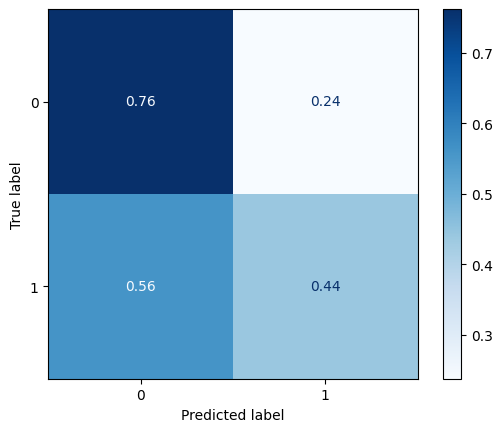

In [30]:
from sklearn.linear_model import LogisticRegression

LogisticRegression = LogisticRegression(C=0.5)
LogisticRegression.fit(x_t, y_t)
preds = LogisticRegression.predict(x_v)

d = {}
# metricas
d['model'] = 'logistic regression'
d['f1 score'] = f1_score(y_v, preds)
print('f1 score: ' + str(d['f1 score']))
d['accuracy'] = accuracy_score(y_v, preds)
print('accuracy: ' + str(d['accuracy']))
d['recall'] = recall_score(y_v, preds)
print('recall: ' + str(d['recall']))
d['precision'] = precision_score(y_v, preds)
print('precision: ' + str(d['precision']))
#confusion matrix
cm = metrics.confusion_matrix(y_v, preds, normalize = 'true')
d['confusion matrix'] = cm
#resultados.append(d)
    
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp = disp.plot(cmap=plt.cm.Blues)
plt.show()

aug roc:  0.6011481861850833


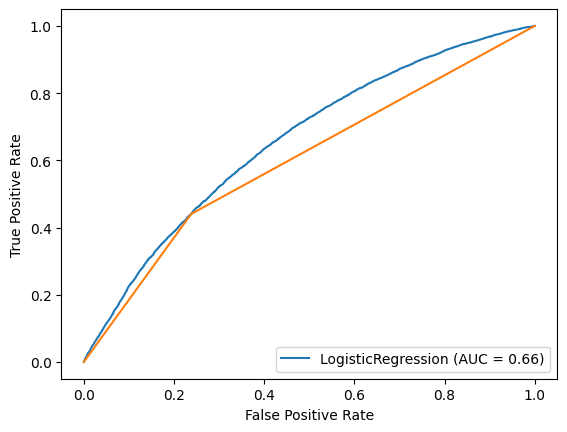

In [31]:
#define metrics
fpr, tpr, _ = metrics.roc_curve(y_v,  preds)
print('aug roc: ', sklearn.metrics.roc_auc_score(y_v,  preds))
RocCurveDisplay.from_estimator(LogisticRegression, x_v, y_v)
#create ROC curve
plt.plot(fpr,tpr)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [34]:
#import os
#os.mkdir('./images/ay')